In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Concatenate
# Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization

from keras.applications.nasnet import NASNetLarge
from keras.applications import VGG16, VGG19

%matplotlib inline

Using TensorFlow backend.


In [3]:
from keras.layers import Dense, concatenate
from keras.models import Model, load_model

In [4]:
from utils.preprocess import multiple_batch_generator
from utils.callbacks import PlotCurves
from utils.load_data import load_data
from utils.comparams import calculate_auc, auc

W0610 19:35:12.563905 140072833486976 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/utils/comparams.py:1: The name tf.local_variables_initializer is deprecated. Please use tf.compat.v1.local_variables_initializer instead.



### Data Preparation

In [5]:
data_dir = './data/'

In [6]:
x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', 
                                               limit=10000, val_limit=10000, is_gzip=True)
len(x_train), len(x_valid)

(10000, 10000)

In [7]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

In [8]:
del train_id
del val_id
del data_dir

# MODEL

In [9]:
dependencies = {
    'auc': auc
}

#### VGG16

In [10]:
model_vgg16 = load_model('Model/vgg16_model_bin_cross_arch_2_lr_0_0001.h5', custom_objects=dependencies)

W0610 19:36:52.951092 140072833486976 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0610 19:36:52.962406 140072833486976 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0610 19:36:52.978968 140072833486976 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0610 19:36:53.184886 140072833486976 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The

In [11]:
for i, layer in enumerate(model_vgg16.layers):
    model_vgg16.layers[i].trainable = False
    model_vgg16.layers[i].name = '{}_{}'.format(layer.name, 'vgg16')

In [12]:
vgg16_out = model_vgg16.layers[-2].output

#### VGG19

In [13]:
model_vgg19 = load_model('Model/vgg19_model_bin_cross_arch_2_lr_0_0001.h5', custom_objects=dependencies)

In [14]:
for i, layer in enumerate(model_vgg19.layers):
    model_vgg19.layers[i].trainable = False
    model_vgg19.layers[i].name = '{}_{}'.format(layer.name, 'vgg19')

In [15]:
vgg19_out = model_vgg19.layers[-2].output

#### NASNET

### Concatination

In [16]:
outs = [vgg16_out, vgg19_out]#, nasnet_out]

In [17]:
merge_0 = concatenate(outs)

In [ ]:
x = Dense(128, activation='relu')(merge_0)
output = Dense(2, activation='softmax', name='main_output')(x)

In [19]:
model = Model(inputs=[model_vgg16.input, model_vgg19.input], outputs=output)
# model = Model(inputs=[model_vgg16.input, model_vgg19.input, nasnet_model.input], outputs=output)

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_vgg19 (InputLayer)      (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1_vgg19 (Conv2D)     (None, 224, 224, 64) 1792        input_1_vgg19[0][0]              
__________________________________________________________________________________________________
block1_conv2_vgg19 (Conv2D)     (None, 224, 224, 64) 36928       block1_conv1_vgg19[0][0]         
__________________________________________________________________________________________________
input_2_vgg16 (InputLayer)      (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_poo

### Compile

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [22]:
optimizer = Adam(lr=0.001)
loss = 'binary_crossentropy'
metrics = ['acc']#, auc]

In [23]:
model.compile(optimizer, loss, metrics)

## Data Generator

In [25]:
model_name = 'ensemble_2_model_bin_cross_arch_2_lr_0_0001'

In [ ]:
generator_num = len(outs)

In [26]:
# Define batch size.
batch_size = 128
n_epoch = 10

# Parameters for generators
train_params = {
    'dim': (224, 224),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': True,
}

val_params = {
    'dim': (224, 224),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': False,
}

# Generators
training_generator = multiple_batch_generator(generator_num, list_IDs=partition['train'],
                                              data=x_train, labels=train_labels, **train_params)
validation_generator = multiple_batch_generator(generator_num, list_IDs=partition['validation'],
                                                data=x_valid, labels=val_labels, **val_params)

# Callbacks,
callbacks = [PlotCurves(model_name=model_name), learning_rate_reduction]

### Fit Generator

In [29]:
steps = int(len(y_train)/batch_size)
val_steps= int(len(y_valid)/batch_size)

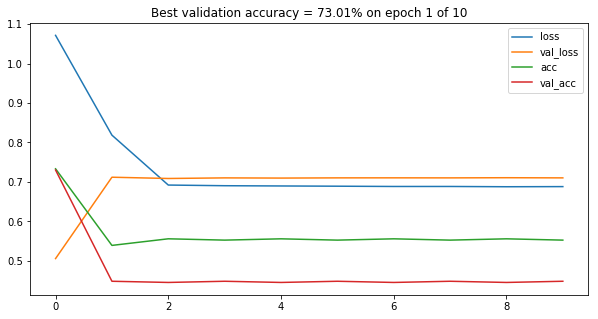

In [30]:
# Training with learning 
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks, steps_per_epoch=steps, validation_steps=val_steps)